In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/5053/"

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import torch

In [20]:
# 数据的差分转换
def difference(array,interval=1):
  diff=list()
  for i in range(interval,len(array)):
    value=array[i]-array[i-interval]
    diff.append(value)
  return pd.Series(diff)

# 对预测的数据进行逆差分转换
def invert_difference(history,yhat,interval=1):
  return yhat+history[-interval]

# 将数据转换为监督学习集，移位后产生的NaN值补0
def timeseries_to_supervised(data,lag=1):
  df=pd.DataFrame(data)
  columns=[df.shift(i) for i in range(1,lag+1)]
  columns.append(df)
  df=pd.concat(columns,axis=1)
  df.fillna(0,inplace=True)
  return df

# 将数据缩放到[-1,1]之间
def scale(train,test):
  # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
  scaler=MinMaxScaler(feature_range=(-1,1))
  # 使用数据来训练缩放器
  scaler=scaler.fit(train)
  # 使用缩放器来将训练集和测试集进行缩放
  train_scaled=scaler.transform(train)
  test_scaled=scaler.transform(test)
  return scaler,train_scaled,test_scaled

# 将预测值进行逆缩放，使用之前训练好的缩放器，x为一维数组，y为实数
def invert_scale(scaler,X,y):
  # 将X,y转换为一个list列表
  new_row=[x for x in X]+[y]
  # 将列表转换为数组
  array=np.array(new_row)
  # 将数组重构成一个形状为[1,2]的二维数组->[[10,12]]
  array=array.reshape(1,len(array))
  # 逆缩放输入的形状为[1,2]，输出形状也是如此
  invert=scaler.inverse_transform(array)
  # 只需要返回y值即可
  return invert[0,-1]

# 构建一个LSTM模型
def fit_lstm(train,batch_size,nb_epoch,neurons):
  # 将数据对中的x和y分开
  X,y=train[:,0:-1],train[:,-1]
  # 将2D数据拼接成3D数据，形状为[N*1*1]
  X=X.reshape(X.shape[0],1,X.shape[1])

  model=Sequential()
  model.add(LSTM(neurons,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),stateful=True))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error',optimizer='adam')
  for i in range(nb_epoch):
    # shuffle是不混淆数据顺序
    his=model.fit(X,y,batch_size=batch_size,verbose=1,shuffle=False)
    # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
    model.reset_states()
  return model

# 开始单步预测
def forecast_lstm(model,batch_size,X):
  # 将形状为[1:]的，包含一个元素的一维数组X，转换形状为[1,1,1]的3D张量
  X=X.reshape(1,1,len(X))
  # 输出形状为1行一列的二维数组yhat
  yhat=model.predict(X,batch_size=batch_size)
  # 将yhat中的结果返回
  return yhat[0,0]

class LSTMForAUD:
  def read_data(self, path):
    data = pd.read_csv(dirpath + 'AUD_v2.csv')
    data.drop(['underlyer','spot','carry','active','version'],axis=1,inplace=True)
    data = data.set_index('timestamp')
    self.series = data
    self.raw_value = self.series.values

  def preprocess(self):
    # diff
    diff_value = difference(self.raw_value,1)
    print("diff_value:\n", diff_value)
    # to supervised
    supervised = timeseries_to_supervised(diff_value,1)
    supervised_value = supervised.values
    print("supervised_value:\n", supervised_value)
    # split, scale
    self.testNum=1000
    train,test=supervised_value[:-self.testNum],supervised_value[-self.testNum:]
    self.scaler, self.train_scaled, self.test_scaled = scale(train,test)
  
  def train(self):
    self.model = fit_lstm(self.train_scaled,1,1,4)

  def test(self):
    test_scaled = self.test_scaled
    # get predictions
    predictions=list()
    for i in range(len(test_scaled)):
      # 将测试集拆分为X和y
      X,y=test_scaled[i,0:-1],test_scaled[i,-1]
      # 将训练好的模型、测试数据传入预测函数中
      yhat=forecast_lstm(self.model,1,X)
      # 将预测值进行逆缩放
      yhat=invert_scale(self.scaler,X,yhat)
      # 对预测的y值进行逆差分
      yhat=invert_difference(self.raw_value,yhat,len(test_scaled)+1-i)
      # 存储正在预测的y值
      predictions.append(yhat)
    self.predictions = predictions
    # plot
    rmse=mean_squared_error(self.raw_value[-self.testNum:],predictions)
    print("Test RMSE:",rmse)
    plt.plot(self.raw_value[-self.testNum:])
    plt.plot(predictions)
    plt.legend(['true','pred'])
    plt.show()

In [21]:
lstm = LSTMForAUD()

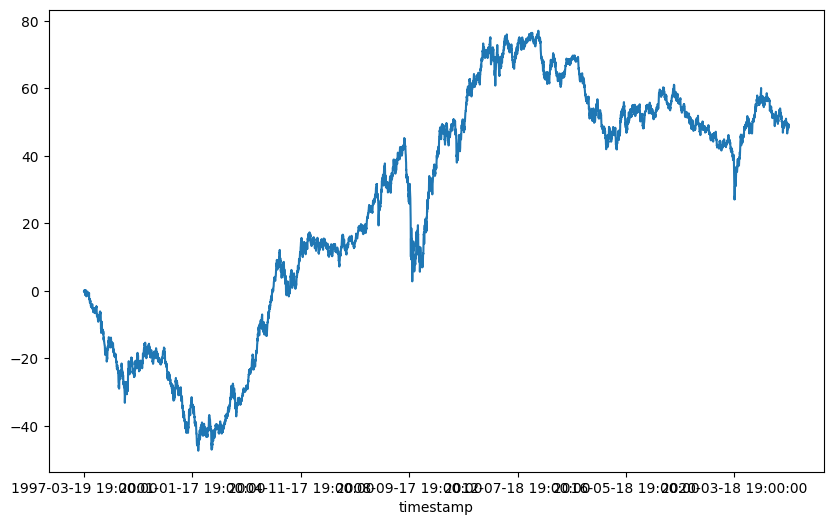

In [22]:
lstm.read_data(dirpath + 'AUD_v2.csv')

plt.figure(figsize=(10, 6))
lstm.series['tri'].plot()
plt.show()

In [23]:
lstm.preprocess()

diff_value:
 0          [0.0900124573554563]
1        [-0.26284866386799866]
2         [0.33629529545001435]
3       [-0.030450998710222082]
4         [-0.6217919718970677]
                 ...           
6495       [0.2741358528045481]
6496      [-0.7909187559996411]
6497      [-0.5149501851641674]
6498       [0.5098481970108111]
6499       [0.4690340996772875]
Length: 6500, dtype: object
supervised_value:
 [[0 array([0.09001246])]
 [array([0.09001246]) array([-0.26284866])]
 [array([-0.26284866]) array([0.3362953])]
 ...
 [array([-0.79091876]) array([-0.51495019])]
 [array([-0.51495019]) array([0.5098482])]
 [array([0.5098482]) array([0.4690341])]]


In [24]:
lstm.train()

5500/5500 [==============================] - 18s 3ms/step - loss: 0.0119


1/1 [==============================] - 0s 25ms/step
Test RMSE: 0.3528391142469024


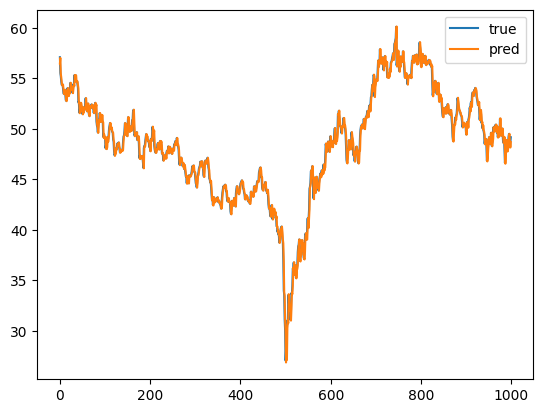

In [25]:
lstm.test()